In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from astropy import units as u, constants as const
from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

from pyphot import (unit, Filter)
import bagpipes as pipes
import emcee

In [2]:
sylt_ids = np.load('../../contrastive_learning/sylt_ids.npz')['ids']
sylt_ids

array([ 980453716, 1143273115, 1197311621, 1228745162, 1271696125,
       1456016600, 1470729144, 1471313744, 1513805078, 1599741416,
       1621863463, 1695974542], dtype=int32)

In [3]:
band_names = ['g','r','i','z','Y','J','K','W1','W2']
eff_wavs = [4862.24, 6460.63, 7850.77, 9199.28, 9906.83, 12681.01, 21588.53, 33526, 46028]

filters_pyphot={} # For deducing photometry from spectra
for band_name, file_name in zip(band_names, [
    "CTIO_DECam.g",
    "CTIO_DECam.r",
    "CTIO_DECam.i",
    "CTIO_DECam.z",
    "CTIO_DECam.Y",
    "Paranal_VISTA.J",
    "Paranal_VISTA.Ks",
    "WISE_WISE.W1",
    "WISE_WISE.W2"
]):
    file = np.loadtxt(f'../filters/{file_name}.dat')

    wave = file[:,0]*unit['AA']
    transmit = file[:,1]
    filters_pyphot[band_name] = Filter(
        wave, transmit, name=band_name, dtype='photon', unit='Angstrom'
    )

filters_list = np.loadtxt('./filters_list_grizYJKW12.txt', dtype="str") # For bagpipes

df = pd.read_csv('../../selecting_data/objs_7102.csv',
                 index_col=0).loc[sylt_ids]
mag_df = df[[f'{band}_mag' for band in band_names]]
magerr_df = df[[f'{band}_magerr' for band in band_names]]
flux_df = df[[f'{band}_flux' for band in band_names]]
fluxerr_df = df[[f'{band}_fluxerr' for band in band_names]]
mag_df

,g_mag,r_mag,i_mag,z_mag,Y_mag,J_mag,K_mag,W1_mag,W2_mag
coadd_object_id,,,,,,,,,
980453716,99.0000,99.000000,23.031525,20.428234,20.438257,19.191986,19.083292,18.946850,18.905692
1143273115,25.0686,23.085131,22.725275,20.184122,20.193619,19.422779,18.890154,19.039086,18.773871
1197311621,99.0000,99.000000,24.378326,20.850765,21.276281,20.657713,19.950358,19.768550,19.267141
1228745162,99.0000,24.031557,21.857098,19.879082,20.034571,19.424444,19.258778,19.306748,19.251762
1271696125,99.0000,99.000000,24.562616,20.508789,20.371948,19.759610,18.981762,18.813231,18.760390
1456016600,99.0000,25.496801,22.687263,20.342350,20.380072,19.915758,19.701619,20.073762,19.911150
1470729144,99.0000,25.624350,23.115353,20.600224,21.004805,20.576065,19.973560,20.024400,19.832961
1471313744,99.0000,99.000000,23.658253,19.883915,20.792187,19.883660,19.193697,18.720948,18.385741
1513805078,99.0000,25.514256,22.932396,20.486546,20.559446,20.254638,20.215853,19.873223,19.881519


<ErrorbarContainer object of 3 artists>

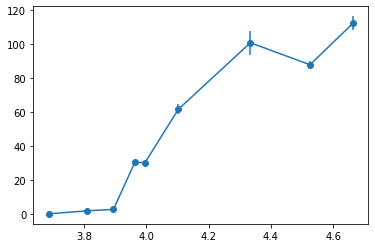

In [4]:
def load_grizYJKW12(ID):    
    ID=int(ID)
    
    fluxes = flux_df.loc[ID]
    fluxerrs = fluxerr_df.loc[ID] / 3 # Table has the 3sigma error; bagpipes probably wants the 1sigma
    photometry = np.vstack((flux_df.loc[ID],
                            fluxerr_df.loc[ID])).T
    return photometry

eg_phot = load_grizYJKW12(sylt_ids[1])
plt.errorbar(
    np.log10(eff_wavs),
    eg_phot[:,0],
    yerr=eg_phot[:,1],
    marker='o'
)

The next code blocks deal with producing a model galaxy, and its photometry and spectroscopy, from a few parameters, using the BAGPIPES package

/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


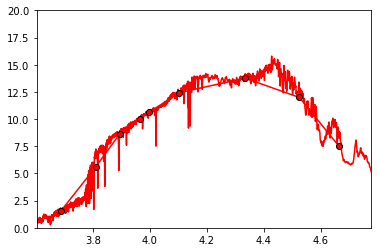

In [5]:
def package_model_components(t0,t1,mass,metallicity,dust_av,zgal):
    """
    Converts a series of galactic parameters into a model_components dictionary
     with a constant star formation rate
    """
    constant = {}  # Star formation - tophat function
    constant["age_max"] = t0 # Time since SF switched on: Gyr
    constant["age_min"] = t1 # Time since SF switched off: Gyr; t1<t0
    constant["massformed"] = mass # vary log_10(M*/M_solar) between 1 and 15
    constant["metallicity"] = metallicity # vary Z between 0 and 2.5 Z_oldsolar

    dust = {}  # Dust component
    dust["type"] = "Calzetti"  # Define the shape of the attenuation curve
    dust["Av"] = dust_av  # magnitudes
    
    nebular = {} # Nebular emission component
    nebular["logU"] = -3

    model_components = {}  # The model components dictionary
    model_components["redshift"] = zgal  # Observed redshift
    model_components["constant"] = constant
    model_components["dust"] = dust
    model_components["nebular"] = nebular
    
    return model_components

model_components = package_model_components(1,.5,10,0.2,0.2,.5) # Require t1<t0
bagpipes_galaxy_model = pipes.model_galaxy(
    model_components,
    filt_list=filters_list,
    spec_wavs=np.arange(4000., 60000., 5.)
)

def galaxy_BAGPIPES_spectroscopy(t0,t1,mass,metallicity,dust_av,zgal):
    """
    Generates a galaxy spectrum, based on a range of parameters.
    This assumes a constant star formation rate. Require t1<t0
    Outputs are in AA, Jy
    """
    model_components = package_model_components(t0, t1, mass, metallicity, dust_av, zgal)
    bagpipes_galaxy_model.update(model_components)
    wavs = bagpipes_galaxy_model.wavelengths # Rest frame
    flxs = bagpipes_galaxy_model.spectrum_full # ergscma
    
    wavs=wavs*u.AA*(1+zgal) # Redshifting
    flxs=flxs*(u.erg/u.s/(u.cm**2)/u.AA)*(wavs**2)/const.c # Converting F_lambda to F_nu
    flxs=flxs.to(u.Jy).value # Jy
    wavs=wavs.value # AA
    return wavs, flxs

def spectrum_to_photometry(wavelengths, fluxes):
    """
    Converts a spectrum to a photometry in grizYJKW12, using pyphot.
    Requires wavelengths to be in angstrom and fluxes to be in jansky
    Returns a 9d vector of the magnitudes in each band, in muJy
    """
    wavelengths*=unit['AA']
    fluxes*=unit['Jy']
    
    band_flxs = np.zeros(len(filters_pyphot))
    for i, band_name in enumerate(band_names):
        band_flxs[i] = filters_pyphot[band_name].get_flux(wavelengths, fluxes) # Jy

    return band_flxs*1e6 # muJy

wavs, flxs = galaxy_BAGPIPES_spectroscopy(1,.5,10,0.2,0.2,.6)
plt.plot(np.log10(wavs), flxs*1e6, c='r')
band_flxs = spectrum_to_photometry(wavs, flxs)
plt.plot(np.log10(eff_wavs), band_flxs, c='r',
        marker='o', mec='k')
plt.xlim(np.log10([4e3,6e4]))
plt.ylim([0,20]);

We now deal with creating a model quasar:

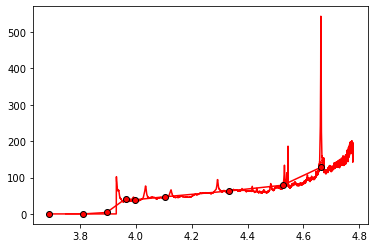

In [6]:
modeldir_dict = {
        'vdb': './quasar_templates/vandenberk2001_z=0_fnu_noscale.txt',
        'sls': './quasar_templates/selsing2016_z=0_fnu_noscale.txt',
        'cln': './quasar_templates/Colina_Quasar_z=0_ETC-Glikman+Hernan-Caballero.txt',
        'mcg': './quasar_templates/mcgreer_z75qso.dat'
    }
model_qso = np.loadtxt(modeldir_dict['vdb'], skiprows=1)

filter_m_1450_file = np.loadtxt('../filters/filter_1450.txt')
def get_1450_filter(z_QSO):
    """
    Retrieves a pyphot filter which is a tophat function around 1450AA
    """
    wave = filter_m_1450_file[:,0] * unit['AA'] *(1+z_QSO)
    transmit = filter_m_1450_file[:,1]
    filter_m_1450 = Filter(wave, transmit, name='1450_tophat', dtype='photon', unit='Angstrom')
    return filter_m_1450

def quasar_spectroscopy(M_QSO, z_QSO):
    """
    Generates a quasar spectrum from a 1450A magnitude and a redshift.
    This will be based on the model chosen (default: vdb)
    Outputs are in AA, Jy
    """
    filter_m_1450 = get_1450_filter(z_QSO)
    # load quasar model, truncate Lyman-alpha forest
    spec_qso = model_qso[:,1]
    spec_qso[model_qso[:,0]*1e4<1215.16] = 0.0
    flux_qso = spec_qso *1e-3 * unit['Jy']                 # Models are apparently given in mJy...
    wavelength = model_qso[:,0]*1e4 *(1+z_QSO) * unit['AA']# ...and wavelengths in microns

    # rescale to desired apparent magnitude 1450 AA
    mag_1450 = -2.5*np.log10(filter_m_1450.get_flux(wavelength,flux_qso)/3631)
    flux_qso *= 10**( (M_QSO - mag_1450 ) / -2.5)
    return wavelength.value, flux_qso.value # in Jy

wavs, flxs = quasar_spectroscopy(20,6)
plt.plot(np.log10(wavs), flxs*1e6, c='r')
band_flxs = spectrum_to_photometry(wavs, flxs)
plt.plot(np.log10(eff_wavs), band_flxs, c='r',
        marker='o', mec='k')

Now, we set up the MCMC fitting program.

In [7]:
def log_prior(theta, obj_type):
    """
    A uniform log prior with boundaries in a realistic range.
    Returns 0 if inside the good range
    Returns -np.inf if outside
    """
    ###### Define the log prior as uniform with boundaries in a realistic range
    if obj_type == 'GQ':
        t0,t1, mass, metallicity, dust_av, zgal, M_QSO, z_QSO = theta
        if (0<t0<13)&(0<t1<t0)&(8<mass<15)&(0<metallicity<2)&(0<dust_av<2)&(0<zgal<4)&(18<M_QSO<24)&(5.5<z_QSO<7):
            return 0.
        
    elif obj_type == 'Q':
        M_QSO, z_QSO = theta
        if (18<M_QSO<24)&(5.5<z_QSO<7):
            return 0.
        
    elif obj_type == 'G':
        t0,t1, mass, metallicity, dust_av, zgal = theta
        if (0<t0<13)&(0<t1<t0)&(8<mass<15)&(0<metallicity<2)&(0<dust_av<2)&(0<zgal<10):
            return 0.
    else:
        raise ValueError(f'Invalid obj_type: {obj_type}. Must be either `G`, `Q`, or `GQ`.')

    return -np.inf

def log_likelihood(theta, y, yerr, obj_type):
    fluxes_model = np.zeros(y.shape) # 9d vector
    
    if obj_type == 'GQ':
        t0,t1, mass, metallicity, dust_av, zgal, M_QSO, z_QSO = theta
    elif obj_type == 'Q':
        M_QSO, z_QSO = theta
    elif obj_type == 'G':
        t0,t1, mass, metallicity, dust_av, zgal = theta
    else:
        raise ValueError(f'Invalid obj_type: {obj_type}. Must be either `G`, `Q`, or `GQ`.')
    
    if 'G' in obj_type:
        wavs, flxs = galaxy_BAGPIPES_spectroscopy(t0,t1,mass, metallicity, dust_av, zgal)
        fluxes_model_galaxy = spectrum_to_photometry(wavs, flxs)
        if np.sum(fluxes_model_galaxy)==0.: # Invalid galaxy params => BAGPIPES gives a blank spectrum
            return -np.inf
        else:
            fluxes_model += fluxes_model_galaxy
        
    if 'Q' in obj_type:
        wavs, flxs = quasar_spectroscopy(M_QSO,z_QSO)
        fluxes_model_quasar = spectrum_to_photometry(wavs, flxs)
        fluxes_model += fluxes_model_quasar

    sigma2 = yerr**2
    return -0.5 * np.sum((y - fluxes_model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, y, yerr, obj_type):
    """
    Bayesian probability update
    """
    lp = log_prior(theta, obj_type)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr, obj_type)

In [8]:
def suggest_init(obj_type):
    """
    Generates an initial set of parameters, randomly distributed around mean_init_row
    """
    mean_init_row = np.array([1,.5,10,0.2,0.2,.5,20,6.])
    if obj_type=='G':
        mean_init_row = mean_init_row[:6]
    elif obj_type=='Q':
        mean_init_row = mean_init_row[6:]
    elif obj_type!='GQ':
        raise ValueError(f'Invalid obj_type: {obj_type}. Must be either `G`, `Q`, or `GQ`.')
    ndim=len(mean_init_row)
    return mean_init_row + np.random.uniform(low=-.01,high=.01,
                                             size=ndim)

def initialise_chains(nwalkers, flux, err_flux, obj_type):
    """
    Returns a set of initial vectors in parameter space, all of which within the prior.
    This is a np array of shape (nwalkers, nparams)
    """
    base_init = suggest_init(obj_type)
    pos = np.tile(base_init, (nwalkers,1))
    i=0
    while np.all(pos[-1,:]==base_init) and i<nwalkers:
        new_row = suggest_init(obj_type)
    
        # Ensure that suggested initial point is actually in the prior
        if (log_prior(new_row, obj_type)!=-np.inf) & (log_likelihood(new_row, flux, err_flux, obj_type)!=-np.inf): 
            pos[i,:] = new_row
            i+=1
    return pos

def fit_sed(flux, err_flux, obj_type,
            nsteps=5000, discard=1000, thin=10, nwalkers=32,
           **kwargs): # kwargs to be passed to EnsembleSampler
    """
    Do the MCMC sampling process to SED-fit the fluxes (and their errors) to a G, Q, or GQ model
    Returns each of the samples, and their log_probs, in a big array.
    """
    
    init = initialise_chains(nwalkers, flux, err_flux, obj_type)
    nwalkers, ndim = init.shape
    
    with Pool() as pool: # Multicore processing
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                        args=(flux, err_flux, obj_type),
                                        pool=pool,
                                       **kwargs)
        sampler.run_mcmc(init, nsteps, progress=True)

    samples = sampler.get_chain(flat=False,thin=thin,discard=discard)
    log_prob = sampler.get_log_prob(flat=False,thin=thin,discard=discard)

    return samples, log_prob

The following will run an MCMC fit for a galaxy+quasar model on the data for the first object. It takes about 7 mins with the default parameters to the `fit_sed` function.

In [ ]:
photometry = load_grizYJKW12(sylt_ids[0])
fluxes_muJy = photometry[:,0]
err_fluxes_muJy = photometry[:,1]

samples, log_prob = fit_sed(flux=fluxes_muJy, err_flux=err_fluxes_muJy, obj_type='GQ',
#                             nsteps=10000, discard=4000, thin=2,
                            nwalkers=32, a=2.
                                ) # ~7min

---
We now begin to analyse the results of the MCMC fitting of all 12 objects to all 3 models. This is done by the file `quasar_galaxy_fit.py` (not `.ipynb`) and are stored in `./mcmc_results.npz`

In [9]:
MODELS=['G','Q','GQ']
mcmc_results = np.load('./mcmc_results.npz')

ids = mcmc_results['ids']
samples_results = {}
samples_results['G'] = mcmc_results['samples_G']
samples_results['Q'] = mcmc_results['samples_Q']
samples_results['GQ'] = mcmc_results['samples_GQ']
log_probs_results = {}
log_probs_results['G'] = mcmc_results['log_probs_G']
log_probs_results['Q'] = mcmc_results['log_probs_Q']
log_probs_results['GQ'] = mcmc_results['log_probs_GQ']

print(ids.shape)
print([samples_results[model].shape for model in MODELS])
print([log_probs_results[model].shape for model in MODELS])

(12,)
[(12, 3000, 32, 6), (12, 3000, 32, 2), (12, 3000, 32, 8)]
[(12, 3000, 32), (12, 3000, 32), (12, 3000, 32)]


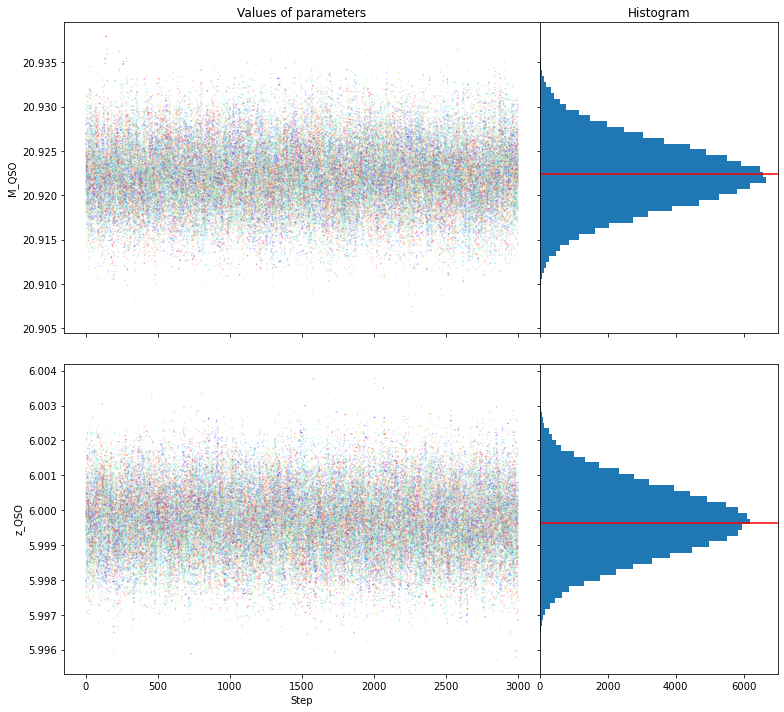

In [10]:
def best_params(samples, log_prob):
    """
    Calculates the set of parameters with the highest probability
    Returns the highest prob set of parameters, and the log of that probability
    """
    nparams = samples.shape[2]
    flat_samples = samples.reshape(
        (samples.shape[0]*samples.shape[1],nparams)
    )
    pred_params = flat_samples[np.argmax(log_prob)]
    max_log_prob = np.max(log_prob)
    return pred_params, max_log_prob

def show_convergence(samples, log_prob, obj_type, burn=0):
    """
    Visualises the sampling over time, and the posterior distributions
    """
    samples = samples[burn:]
    log_prob = log_prob[burn:]
    nparams = samples.shape[2]
    fg, axs = plt.subplots(nparams,2,figsize=(11,4+3*nparams), sharey='row', sharex='col',
                           gridspec_kw={'width_ratios':[2,1]})
    pred_params, _ = best_params(samples, log_prob)
    params = ["t0","t1","mass", "metallicity", "dust_av", "z_G", "M_QSO", 'z_QSO']
    if obj_type=='G':
        params = params[:6]
    elif obj_type=='Q':
        params = params[6:]
    
    flat_samples = samples.reshape(
        (samples.shape[0]*samples.shape[1],nparams)
    )
    
    for i in range(nparams):
        param_samples = samples[:,:,i].reshape(samples.shape[0]*samples.shape[1])
        
        x = np.tile(np.arange(samples.shape[0]), (samples.shape[1],1)).T.reshape(samples.shape[0]*samples.shape[1])
        axs[i,0].scatter(x, param_samples,
                         s=.01, c=np.arange(param_samples.shape[0])%samples.shape[1],
                         cmap='rainbow')
        axs[i,0].set_ylabel(params[i])
        axs[i,1].hist(flat_samples[:,i], orientation='horizontal', bins=50)
        axs[i,1].axhline(pred_params[i], c='r')
    axs[0,0].set_title('Values of parameters')
    axs[0,1].set_title('Histogram')
    axs[nparams-1,0].set_xlabel('Step')
    fg.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.1)
    return fg

fg = show_convergence(
    samples_results['Q'][ids==ids[10],:,:,:][0],
    log_probs_results['Q'][ids==ids[10],:,:][0],
    'Q'
)

In [28]:
best_params_dict = {}
nparams = {
    'G':6,
    'Q':2,
    'GQ':8
}
for model in MODELS:
    best_params_model = np.zeros((len(ids), nparams[model]))
    for idd in ids:
        samples = samples_results[model][ids==idd,:,:,:][0]
        log_probs = log_probs_results[model][ids==idd,:,:][0]
        best_params_model[ids==idd,:], _ = best_params(samples, log_probs)
    best_params_dict[model] = best_params_model
np.savez_compressed(
    'best_params.npz',
    param_order = ['t0',]
    G=best_params_dict['G'],
    Q=best_params_dict['Q'],
    GQ=best_params_dict['GQ']
)

In [29]:
best_params_dict

{'G': array([[5.49097794e-01, 5.12157471e-01, 1.16041556e+01, 4.00019408e-01,
         1.19401272e+00, 1.27551744e+00],
        [5.51306549e-01, 4.77269830e-01, 1.18313309e+01, 2.00012753e-02,
         1.74470691e+00, 1.27617152e+00],
        [5.30148534e-01, 4.63570372e-01, 1.12753695e+01, 4.00100635e-01,
         1.07186017e+00, 1.26984864e+00],
        [4.84050441e-01, 4.53631735e-01, 1.15818792e+01, 4.00001923e-01,
         9.80078825e-01, 1.21750211e+00],
        [5.11553758e+00, 4.59831272e+00, 1.19652477e+01, 1.48963546e+00,
         1.90916622e-06, 1.14298103e+00],
        [5.08707561e-01, 4.46514197e-01, 1.12174677e+01, 4.00008820e-01,
         6.80265778e-01, 1.21816881e+00],
        [5.14072187e-01, 4.51828122e-01, 1.12454189e+01, 4.00007550e-01,
         9.81097123e-01, 1.22211922e+00],
        [5.24472422e-01, 4.71352251e-01, 1.17296066e+01, 4.00002558e-01,
         1.16709390e+00, 1.26983100e+00],
        [3.42092079e+00, 2.80565547e+00, 1.15594910e+01, 8.73972349e-01,
  

In [ ]:
nparams_inv = {v: k for k, v in nparams.items()}

wavs = np.logspace(np.log10(4e3),np.log10(6e4), num=10000)
def spectrum_from_params(params):
    """
    Retrieves the spectrum of a model from its parameter list
    """
    ot = nparams_inv[len(params)]
    fluxes = np.zeros_like(wavs)
    if 'G' in ot:
        wvs, fxs = galaxy_BAGPIPES_spectroscopy(
            params[0], params[1], params[2], params[3], params[4], params[5]
        )
        fluxes += np.interp(wavs, wvs, fxs)
    if 'Q' in ot:
        wvs, fxs = quasar_spectroscopy(
            params[-2], params[-1]
        )
        fluxes += np.interp(wavs, wvs, fxs)
    return fluxes * 1e6 # muJy

plt.plot(np.log10(wavs), 
         spectrum_from_params(
             best_params_dict['GQ'][0,:]
         )
        )

In [ ]:
def BICs(idd):
    """
    Returns the BICs for G, Q, GQ models for a given ID
    BIC = -2lnL + JlnN
    """
    bics = np.zeros(3)
    for i, model in enumerate(MODELS):
        _, lnL = best_params(
            samples_results[model][ids==idd,:,:][0],
            log_probs_results[model][ids==idd,:][0]
        )
        bics[i] = -2*lnL + nparams[model]*np.log(9)
    return bics
bics = np.zeros((len(ids),3))
for i, idd in enumerate(ids):
    bics[i,:] = BICs(idd)
bics

In [ ]:
idd=ids[11]

best_obj_params = [best_params_dict[model][ids==idd,:][0] for model in MODELS]
model_spectra = np.array([spectrum_from_params(param_set) for param_set in best_obj_params])

fg, ax = plt.subplots(figsize=(10,7))
ax.errorbar(
    np.log10(eff_wavs),
    [df.loc[idd][f'{band}_flux'] for band in band_names],
    yerr=[df.loc[idd][f'{band}_fluxerr'] for band in band_names],
    c='r', marker='o',capsize=7,elinewidth=2, mew=2, mec='k',# markersize=10
)

ax.plot(
    np.log10(wavs), model_spectra[0,:], 'g',
    np.log10(wavs), model_spectra[1,:], 'orange',
    np.log10(wavs), model_spectra[2,:], 'm'
)

ax.legend(
    [f'{MODELS[i]}: BIC$=${bics[ids==idd][0][i]:.1f}' \
           for i in range(3)] + ['True fluxes'],
    fontsize=16
)

model_fluxes = np.array([
    filters_pyphot[band_name].get_flux(
        wavs*unit['AA'],
        model_spectra*1e-6*unit['Jy']
    )*1e6 for band_name in band_names
]).T
ax.plot(np.log10(eff_wavs), model_fluxes[0,:], 'g',
        np.log10(eff_wavs), model_fluxes[1,:], 'orange',
        np.log10(eff_wavs), model_fluxes[2,:], 'b',
        marker='o', lw=0, mec='k')
ax.set_xlim(np.log10([4e3, 6e4]))
ax.set_ylim(np.max(model_fluxes)*np.array([-.05,1.6]))

ax.set_title(
    f'ID: {idd}',
    fontsize=24
);

fg.savefig(f'fitting_spectra/{idd}.png')

In [106]:
spectra = np.zeros((len(ids), 3, len(wavs)))
for i, idd in enumerate(ids):
    spectra[i,0,:] = spectrum_from_params(best_params_dict['G'][ids==idd,:][0])
    spectra[i,1,:] = spectrum_from_params(best_params_dict['Q'][ids==idd,:][0])
    spectra[i,2,:] = spectrum_from_params(best_params_dict['GQ'][ids==idd,:][0])
                   
np.savez_compressed(
    'update_romain/bagpipes_ids_spectra.npz',
    ids=ids,
    wavelengths=wavs,
    spectra=spectra
)

In [105]:
spectra.shape

(12, 3, 10000)

In [102]:
mag_df['ra'] = df.loc[ids, 'ra_des']
mag_df['dec']= df.loc[ids, 'dec_des']
mag_df.to_csv('update_romain/ids_mags_coords.csv')

/tmp/ipykernel_81935/3767387074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag_df['ra'] = df.loc[ids, 'ra_des']
/tmp/ipykernel_81935/3767387074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag_df['dec']= df.loc[ids, 'dec_des']
